In [2]:
import numpy as np
import matplotlib.pyplot as plt
from types import SimpleNamespace
from scipy.optimize import minimize

def setup(ax):
    ax.tick_params(direction='in', length=10, width=4, colors='black')
    ax.spines['left'].set_linewidth(3)
    ax.spines['right'].set_linewidth(3)
    ax.spines['top'].set_linewidth(3)
    ax.spines['bottom'].set_linewidth(3)
    #ax.spines['right'].set_color('none')
    #ax.spines['left'].set_color('none')
    #ax.yaxis.set_major_locator(ticker.NullLocator())
    #ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(which='major', direction='in',width=3.00,length=7,labelsize=24)
    ax.tick_params(which='major', direction='in',width=3.00,length=7,labelsize=24)
    ax.tick_params(which='minor', direction='in', width=2.00,length=5)
    ax.tick_params(which='minor', direction='in',width=2.00,length=5)
    ax.patch.set_alpha(0.0)

Fig 1:

C:\Users\longyu\AppData\Local\Temp\ipykernel_82756\3221333264.py:236: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


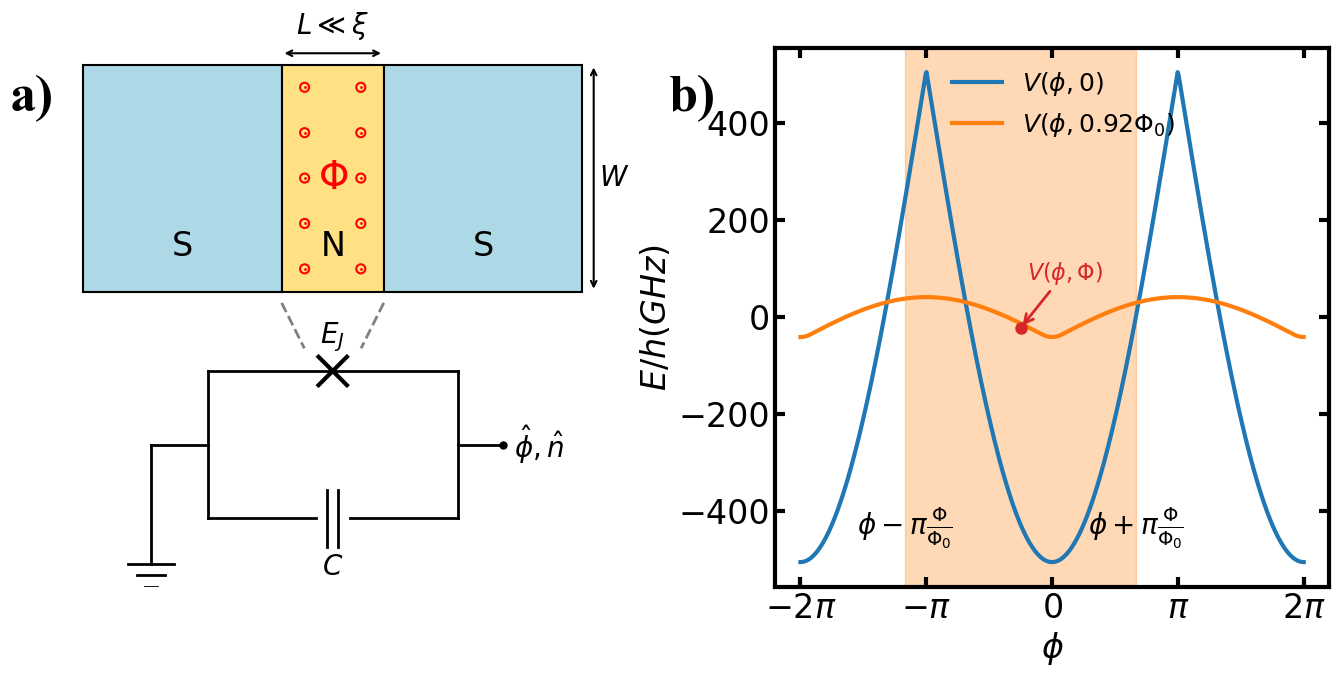

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.integrate import quad
from matplotlib import rcParams

# ==========================================
# 1. LEFT PANEL: DRAWING THE SCHEMATIC
# ==========================================
def draw_schematic(ax):
    # The drawing starts at x=0.5. Setting limits close to the content removes whitespace.
    ax.set_xlim(-0.4, 9.8)  
    ax.set_ylim(0.0, 9.5)
    ax.set_aspect('equal')
    ax.axis('off')

    # --- GEOMETRY PARAMETERS ---
    y_top_box = 5.2
    h_box = 4.0       # Height of the junction
    w_s = 3.5         # Width of Superconducting leads
    w_n = 1.8         # Width of Normal junction
    x_start = 0.5     # Start x position
    
    # Coordinates
    x_s1_end = x_start + w_s
    x_n_end = x_s1_end + w_n
    x_s2_end = x_n_end + w_s
    xc = x_start + w_s + w_n/2  # Center of the junction
    yc = y_top_box + h_box/2    # Center Y of the junction

    # Colors
    c_s = '#ADD8E6' # Light Blue
    c_n = '#FFE082' # Light Orange/Yellow

    # --- 1. Draw Boxes ---
    # Left S
    rect_left = patches.Rectangle((x_start, y_top_box), w_s, h_box, 
                                  linewidth=1.5, edgecolor='black', facecolor=c_s)
    ax.add_patch(rect_left)
    ax.text(x_start + w_s/2, y_top_box + 0.5, r'S', 
            ha='center', va='bottom', fontsize=24, color='black')

    # Middle N
    rect_mid = patches.Rectangle((x_s1_end, y_top_box), w_n, h_box, 
                                 linewidth=1.5, edgecolor='black', facecolor=c_n)
    ax.add_patch(rect_mid)
    
    # Right S
    rect_right = patches.Rectangle((x_n_end, y_top_box), w_s, h_box, 
                                   linewidth=1.5, edgecolor='black', facecolor=c_s)
    ax.add_patch(rect_right)
    ax.text(x_n_end + w_s/2, y_top_box + 0.5, r'S', 
            ha='center', va='bottom', fontsize=24, color='black')

    # --- 2. Red Circles & Phi Label ---
    # ADJUSTMENT: Continuous column without space for Phi
    
    # X coordinates for the two columns
    col_spacing = w_n * 0.55
    col_x = [xc - col_spacing/2, xc + col_spacing/2]
    
    # Y coordinates: 
    # Create 5 evenly spaced points centered around yc
    # Height is 4.0, spacing ~0.8 fits 5 circles perfectly (-1.6 to +1.6)
    y_offsets = np.linspace(-1.6, 1.6, 5)

    for x_c in col_x:
        for dy in y_offsets:
            # Draw Red Circle (open)
            circ = patches.Circle((x_c, yc + dy), 0.08, fill=False, edgecolor='red', lw=1.5)
            ax.add_patch(circ)
            ax.plot(x_c, yc + dy, 'o', color='red', markersize=1)

    # Label Phi (Red, centered)
    # Added zorder=10 to make sure text sits on top of the circle line if they overlap
    ax.text(xc, yc, r'$\Phi$', color='red', fontsize=28, ha='center', va='center', zorder=10)
    
    # Label N (Bottom of yellow region)
    ax.text(xc, y_top_box + 0.5, r'N', 
            ha='center', va='bottom', fontsize=24, color='black')


    # --- 3. Dimension Annotations ---
    # W (Height) - Arrow on the far right
    x_dim_w = x_s2_end + 0.2
    ax.annotate('', xy=(x_dim_w, y_top_box), xytext=(x_dim_w, y_top_box + h_box),
                arrowprops=dict(arrowstyle='<->', lw=1.5))
    ax.text(x_dim_w + 0.1, yc, r'$W$', va='center', fontsize=20)

    # L << xi (Top)
    y_dim_L = y_top_box + h_box + 0.2
    ax.annotate('', xy=(x_s1_end, y_dim_L), xytext=(x_n_end, y_dim_L),
                arrowprops=dict(arrowstyle='<->', lw=1.5))
    ax.text(xc, y_dim_L + 0.2, r'$L \ll \xi$', ha='center', va='bottom', fontsize=20)


    # --- 4. Circuit Diagram ---
    yc_top = 3.8  # Top wire y
    yc_bot = 1.2  # Bottom wire y
    hw = 2.2      # Half width of circuit loop

    # Dashed lines connecting physics to circuit
    ax.plot([x_s1_end, xc - 0.5], [y_top_box-0.2, yc_top + 0.4], 
            ls='--', lw=2, color='gray')
    ax.plot([x_n_end, xc + 0.5], [y_top_box-0.2, yc_top + 0.4], 
            ls='--', lw=2, color='gray')

    # Main Loop Box
    # Top wire (broken by JJ)
    ax.plot([xc - hw, xc + hw], [yc_top, yc_top], 'k-', lw=2)
    # Bottom wire (broken by Cap)
    ax.plot([xc - hw, xc - 0.3], [yc_bot, yc_bot], 'k-', lw=2)
    ax.plot([xc + 0.3, xc + hw], [yc_bot, yc_bot], 'k-', lw=2)
    # Side wires
    ax.plot([xc - hw, xc - hw], [yc_bot, yc_top], 'k-', lw=2)
    ax.plot([xc + hw, xc + hw], [yc_bot, yc_top], 'k-', lw=2)

    # Josephson Junction (X symbol)
    sz = 0.25
    ax.plot([xc - sz, xc + sz], [yc_top - sz, yc_top + sz], 'k-', lw=3)
    ax.plot([xc - sz, xc + sz], [yc_top + sz, yc_top - sz], 'k-', lw=3)
    ax.text(xc, yc_top + 0.5, r'$E_J$', ha='center', fontsize=20)

    # Capacitor
    ax.plot([xc - 0.1, xc - 0.1], [yc_bot - 0.5, yc_bot + 0.5], 'k-', lw=2)
    ax.plot([xc + 0.1, xc + 0.1], [yc_bot - 0.5, yc_bot + 0.5], 'k-', lw=2)
    ax.text(xc, yc_bot - 1, r'$C$', ha='center', fontsize=20)

    # Ground connection
    ax.plot([xc - hw, xc - hw - 1.0], [yc_bot + (yc_top-yc_bot)/2, yc_bot + (yc_top-yc_bot)/2], 'k-', lw=2)
    ax.plot([xc - hw - 1.0, xc - hw - 1.0], [yc_bot + (yc_top-yc_bot)/2, 0.4], 'k-', lw=2)
    
    # Ground symbol
    gx_g, gy_g = xc - hw - 1.0, 0.4
    ax.plot([gx_g - 0.4, gx_g + 0.4], [gy_g, gy_g], 'k-', lw=2)
    ax.plot([gx_g - 0.25, gx_g + 0.25], [gy_g - 0.2, gy_g - 0.2], 'k-', lw=2)
    ax.plot([gx_g - 0.1, gx_g + 0.1], [gy_g - 0.4, gy_g - 0.4], 'k-', lw=2)

    # Output terminals
    ax.plot([xc + hw, xc + hw + 0.8], [yc_bot + (yc_top-yc_bot)/2, yc_bot + (yc_top-yc_bot)/2], 'k-', lw=2)
    ax.plot(xc + hw + 0.8, yc_bot + (yc_top-yc_bot)/2, 'ko', markersize=5)
    ax.text(xc + hw + 1.0, yc_bot + (yc_top-yc_bot)/2, r'$\hat{\phi}, \hat{n}$', va='center', fontsize=20)

    # Panel Label
    ax.text(0.0, 0.95, 'a)', transform=ax.transAxes, fontweight='bold', 
            fontfamily='Times New Roman', fontsize=38, ha='center', va='top')

# ==========================================
# 2. RIGHT PANEL: PHYSICS CALCULATION
# ==========================================
# Parameters
Phi0 = 1.0
Delta = 50.7
Tp = 1.0
p = 20
N = 600
Ec = 0.2

# Define φ grid
phi_vals_extended = np.linspace(-2 * np.pi, 2 * np.pi, 600)

# Potential Definitions
def V_exact(phi, Phi):
    if Phi == 0:
        return 0
    Λ = np.pi * Phi / Phi0
    prefac = -Phi0 / (2 * np.pi * Phi)
    f = lambda θ: Delta * np.sqrt(max(0, 1 - Tp * np.sin(θ / 2) ** 2))
    # Using scipy.integrate.quad
    I, _ = quad(f, phi - Λ, phi + Λ, limit=300)
    return p * prefac * I

def V_normalized(phi_vals, Phi):
    V_raw = np.array([V_exact(phi, Phi) for phi in phi_vals])
    V_min, V_max = np.min(V_raw), np.max(V_raw)
    V_centered = V_raw - (V_max + V_min) / 2
    return V_centered, (V_max - V_min) / 2

def draw_potential_plot(ax):
    # Compute potentials
    # Small Phi for limit ~ 0
    V_left, EJ_0 = V_normalized(phi_vals_extended, Phi=0.000001)
    V_left092, EJ_092 = V_normalized(phi_vals_extended, Phi=0.92)

    # Parameters for highlighting region
    phi0 = -np.pi / 4
    Phi_demo = 0.92
    Lambda = np.pi * Phi_demo / Phi0
    V_raw_demo = np.array([V_exact(phi, Phi_demo) for phi in phi_vals_extended])
    V_demo_normalized = V_raw_demo - np.mean(V_raw_demo)
    idx_phi0 = np.argmin(np.abs(phi_vals_extended - phi0))
    V_phi0_val = V_demo_normalized[idx_phi0]

    # Plotting
    ax.plot(phi_vals_extended, V_left, color='C0', linewidth=3, label=r'$V(\phi,0)$')
    ax.plot(phi_vals_extended, V_left092, color='C1', linewidth=3, label=r'$V(\phi,0.92\Phi_0)$')

    # Highlight selected φ-point
    ax.plot(phi0, V_phi0_val, 'o', color='C3', markersize=8)
    ax.annotate(r'$V(\phi,\Phi)$', xy=(phi0, V_phi0_val),
                xytext=(phi0 + 0.15, V_phi0_val + 100),
                arrowprops=dict(arrowstyle='->', lw=2, color='C3'),
                fontsize=16, color='C3')

    # Highlight integration region
    ax.axvspan(phi0 - Lambda, phi0 + Lambda, color='C1', alpha=0.3)
    ax.text(phi0 - Lambda, -450, r'$\phi-\pi \frac{\Phi}{\Phi_0}$', fontsize=20, ha='center')
    ax.text(phi0 + Lambda, -450, r'$\phi+\pi \frac{\Phi}{\Phi_0}$', fontsize=20, ha='center')

    # Axis labels and ticks
    ax.set_xlabel(r'$\phi$', fontsize=24)
    ax.set_ylabel(r'$E/h(GHz)$', fontsize=24)
    ax.set_xticks([-2*np.pi, -np.pi, 0, np.pi, 2*np.pi])
    ax.set_xticklabels([r'$-2\pi$', r'$-\pi$', r'$0$', r'$\pi$', r'$2\pi$'], fontsize=22)

    # Legend
    ax.legend(fontsize=18, frameon=False, loc='upper center', bbox_to_anchor=(0.52, 1.0))
    
    # Panel Label
    ax.text(-0.15, 0.95, 'b)', transform=ax.transAxes, fontweight='bold', 
            fontfamily='Times New Roman', fontsize=38, ha='center', va='top')
    
    # Apply style
    setup(ax)
# ==========================================
# 3. MAIN EXECUTION
# ==========================================
def main():
    # Adjust width ratios and spacing to optimize layout
    fig, axes = plt.subplots(1, 2, figsize=(18, 7), 
                             gridspec_kw={'width_ratios': [1.4, 1], 'wspace': 0.1})

    draw_schematic(axes[0])
    draw_potential_plot(axes[1])

    plt.tight_layout()
    plt.savefig('Fig1.pdf', bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    main()

Fig 2 and Fig 3 without inset:

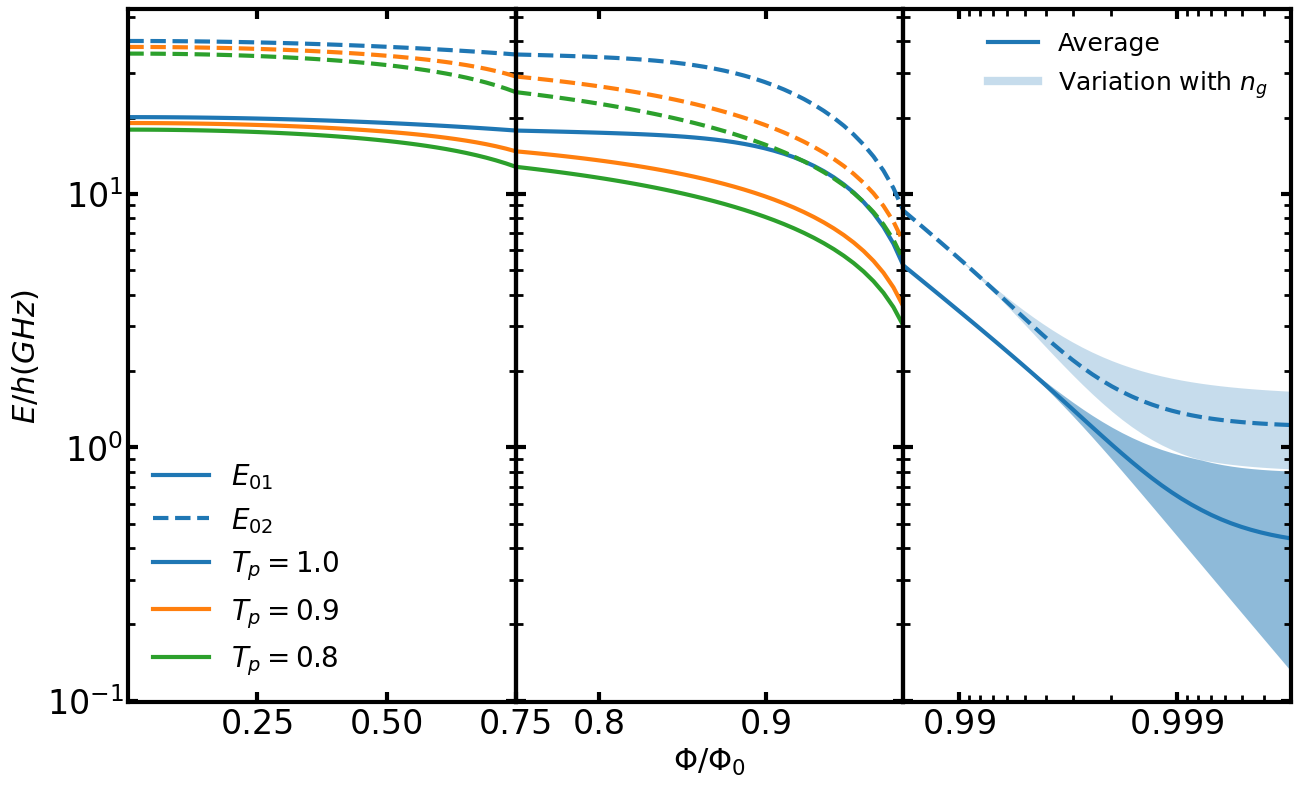

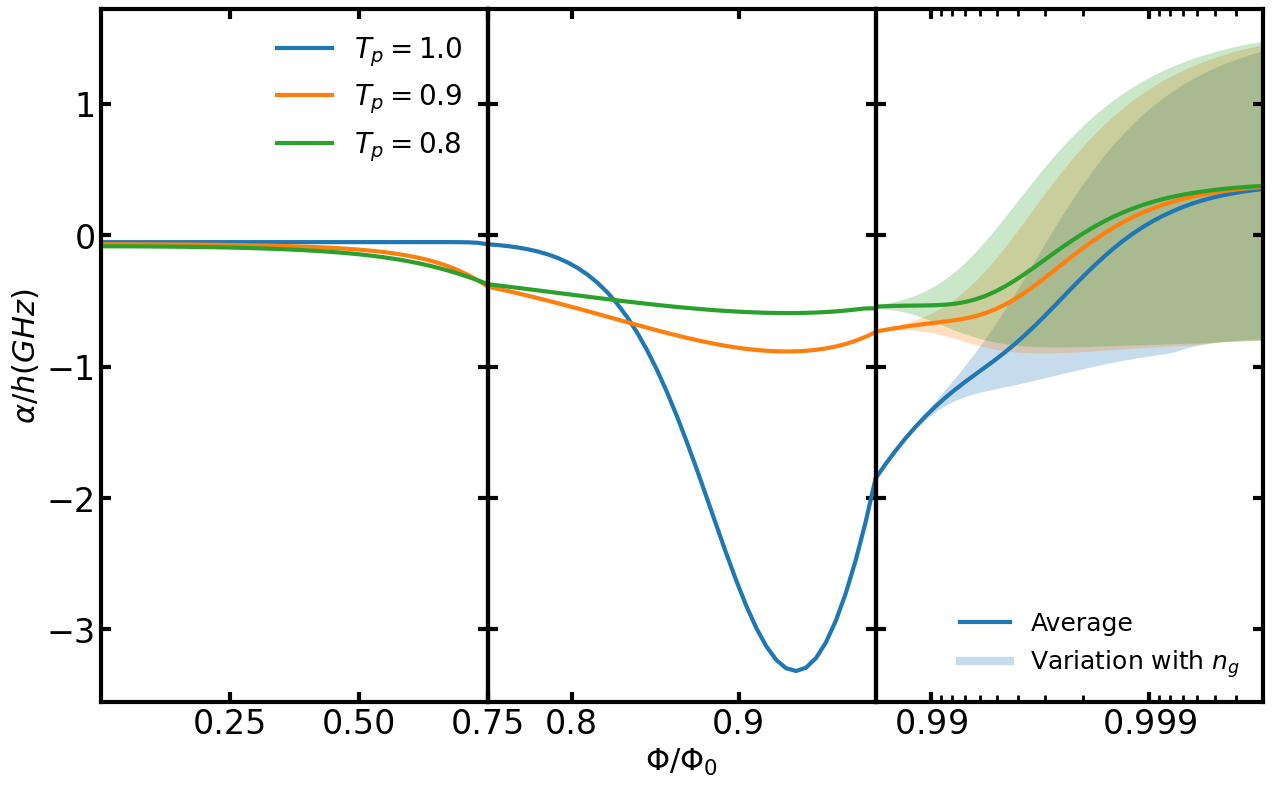

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.linalg import eigh
import matplotlib.lines as mlines
import matplotlib.ticker as ticker

# ==============================================================  
# 0) Constants  
# ==============================================================  
Ec = 2e-1
N = 600
dφ = 2 * np.pi / N
Phi0 = 1.0
Delta = 50.7
lam = 4 * Ec / dφ**2
p = 20

# ==============================================================  
# 1) Flux ranges and energy-level block (exact as you provided)  
# ==============================================================  
flux_1 = []
x_log = []
major_ticks = [1 - 0.99, 1 - 0.999] # 1-Φ; will be used later for ticks

# --- Energy-level block exactly as you gave it ---
# Transform x-axis for last panel
figsize = (20, 8)

# Flux ranges for panels 1&2
flux_1 = np.linspace(0.0001, 0.75, 40)
flux_2 = np.linspace(0.75, 0.982, 40)
flux_range = np.concatenate([flux_1, flux_2])
phi_vals = np.linspace(-np.pi, np.pi, N)

# Potential/Hamiltonian functions (same as before)
def V_exact(phi, Phi, Tp_array=[1.0]):
    Λ = np.pi * Phi / Phi0
    prefac = -Phi0 / (2 * np.pi * Phi)
    total = 0.0
    for Tp_i in Tp_array:
        integrand = lambda θ: Delta * np.sqrt(1 - Tp_i * np.sin(θ/2)**2)
        I, _ = quad(integrand, phi - Λ, phi + Λ, limit=500)
        total += p * prefac * I
    return total

def build_phase_hamiltonian_numeric(Phi, theta=0.0, Tp_array=[1.0]):
    H = np.zeros((N, N), dtype=complex)
    V_arr = np.zeros(N)
    for j in range(N):
        φ = (j - N/2) * dφ
        V_arr[j] = V_exact(φ, Phi, Tp_array)
        H[j, j] = 2 + V_arr[j] / lam
        if j > 0:
            H[j, j-1] = H[j-1, j] = -1
    H[0, -1] = -np.exp(1j * theta)
    H[-1, 0] = -np.exp(-1j * theta)
    return lam * H, V_arr

# ==============================================================  
# 3) Energy levels (two T_p)  
# ==============================================================  
Tp_energy = [1.0, 0.9, 0.8]
Tp_colors = ['C0', 'C1', 'C2']
E_linestyles = ['-', '--']  # 3 energy states
E_levels = {Tp: [] for Tp in Tp_energy}

for Tp_i in Tp_energy:
    for Phi in flux_range:
        H, V = build_phase_hamiltonian_numeric(Phi=Phi, Tp_array=[Tp_i])
        E_vals, _ = eigh(H)
        E0, E1, E2 = E_vals[:3]
        E10 = E1 - E0
        E20 = E2 - E0
        E_levels[Tp_i].append([E10, E20])
    E_levels[Tp_i] = np.array(E_levels[Tp_i])

# ==============================================================  
# 4) Flux masks  
# ==============================================================  
seg1_mask = flux_range <= 0.75
seg2_mask = (flux_range >= 0.75) & (flux_range <= 0.982)
seg3_mask = flux_range >= 0.982  # note: flux_range doesn't include >0.99 points, used only for consistency

# ==============================================================  
# 5) Plot energy levels (three panels)  
# ==============================================================  
fig, axes = plt.subplots(1, 3, figsize=(15,9), sharey=True, gridspec_kw={'wspace':0.0})

for idx, (mask, label) in enumerate([(seg1_mask,'0–0.75'),(seg2_mask,'0.75–0.985')]):
    ax = axes[idx]
    flux_seg = flux_range[mask]
    for i, ls in enumerate(E_linestyles):
        for Tp_i, col in zip(Tp_energy, Tp_colors):
            ax.plot(flux_seg, E_levels[Tp_i][mask,i], color=col, linestyle=ls, lw=3)
    # ax.set_xlabel(r'$\Phi/\Phi_0$', fontsize=22)
    ax.set_xlim(flux_seg[0], flux_seg[-1])   # flush to axis edges
    setup(ax)

# Legend
energy_handles = [mlines.Line2D([], [], color='C0', lw=3, linestyle=ls) for ls in E_linestyles]
energy_labels = [r'$E_{01}$', r'$E_{02}$']
Tp_handles = [mlines.Line2D([], [], color=c, lw=3, linestyle='-') for c in Tp_colors]
Tp_labels = [r'$T_p=1.0$', r'$T_p=0.9$', r'$T_p=0.8$']
axes[0].legend(energy_handles + Tp_handles, energy_labels + Tp_labels, fontsize=20, frameon=False)
axes[0].set_ylabel(r'$E/h (GHz)$', fontsize=22)
# axes[0].text(-1.2, 1, 'a)', transform=ax.transAxes,fontweight='bold',fontfamily='Times New Roman',fontsize=38, ha='center', va='top')
# ==============================================================  
# 6) Last panel energy-levels (your exact function block)  
# ==============================================================  
# ==============================================================  
ax3 = axes[2]

# --- Log-spaced flux (Φ = 0.982 → 0.9999) ---
phi_min, phi_max = 0.982, 0.9997
x_min, x_max = 1 - phi_max, 1 - phi_min  # 0.0001 → 0.018
x_log = np.logspace(np.log10(x_max), np.log10(x_min), 40)
flux_log = 1 - x_log

# --- Setup axis ---
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xticks(major_ticks)
ax3.set_xticklabels([r'$0.99$', r'$0.999$'])
# ax3.set_xlabel(r'$\Phi/\Phi_0$', fontsize=22)
axes[1].set_xlabel(r'$\Phi/\Phi_0$', fontsize=22)
ax3.set_xlim(x_log[0], x_log[-1])

# --- Define n_g values ---
ng_edges = [0.0, 0.5]               # boundaries for shading
ng_samples = np.linspace(0, 0.5, 11)  # intermediate for averaging
E_linestyles = ['-', '--']   # 3 lowest energy states
E_alpha= [0.5, 0.25]
# --- Compute energy levels ---
levels_ng_dict = {}
for ng in ng_edges + list(ng_samples):
    theta = 2 * np.pi * ng
    levels = []
    for Phi in flux_log:
        H, V = build_phase_hamiltonian_numeric(Phi=Phi, theta=theta, Tp_array=[1.0])
        E_vals, _ = eigh(H)
        E0, E1, E2 = E_vals[:3]
        E10 = E1 - E0
        E20 = E2 - E0

        levels.append([E10, E20])
    levels_ng_dict[ng] = np.array(levels)

# --- Shade region between n_g=0 and n_g=0.5 ---
levels_0 = levels_ng_dict[0.0]
levels_05 = levels_ng_dict[0.5]
for i, alp in enumerate(E_alpha):
    ax3.fill_between(x_log, levels_0[:, i], levels_05[:, i], color='C0', alpha=alp, lw=0)

# --- Plot average over intermediate n_g values ---
levels_avg = np.mean(np.stack([levels_ng_dict[ng] for ng in ng_samples]), axis=0)
for i, ls in enumerate(E_linestyles):
    ax3.plot(x_log, levels_avg[:, i], color='C0', lw=3, linestyle=ls)

# --- Add legend for clarity ---
ng_handles = [
    mlines.Line2D([], [], color='C0', lw=3, linestyle='-'),
    mlines.Line2D([], [], color='C0', lw=6, alpha=0.25),
]
ng_labels = [r'Average', r'Variation with $n_g$']
ax3.legend(ng_handles, ng_labels, fontsize=18, frameon=False)

ax3.set_xlim(x_log[0], x_log[-1])
setup(ax3)

# ==============================================================  
# 7) Compute anharmonicities (include 3 T_p here)  
# ==============================================================  
Tp_energy_last = [1.0, 0.9,0.8]  # Three Tp for anharmonicities
anh = {}
analytic_anh = {}
for Tp_i in Tp_energy_last:
    E_vals = []
    for Phi in flux_range:
        H, V = build_phase_hamiltonian_numeric(Phi=Phi, Tp_array=[Tp_i])
        E, _ = eigh(H)
        E_vals.append(E[:3] - np.min(V))
    E_vals = np.array(E_vals)
    anh[Tp_i] = (E_vals[:,2] - E_vals[:,1]) - (E_vals[:,1] - E_vals[:,0])


# ==============================================================  
# 8) Plot anharmonicities (3-panel figure) — updated to match energy-level layout
# ==============================================================  
figD, axesD = plt.subplots(1, 3, figsize=(15, 9), sharey=True, gridspec_kw={'wspace': 0.0})

# Panels 1 & 2: linear-linear numeric vs analytic
for idx, mask in enumerate([seg1_mask, seg2_mask]):
    ax = axesD[idx]
    flux_seg = flux_range[mask]
    # numeric colored lines for each Tp
    for Tp_i, col in zip(Tp_energy_last, ['C0','C1','C2']):
        ax.plot(flux_seg, anh[Tp_i][mask], color=col, lw=3, linestyle='-')
    # ax.set_xlabel(r'$\Phi/\Phi_0$', fontsize=22)
    ax.set_xlim(flux_seg[0], flux_seg[-1])  
    setup(ax)
# axesD[1].text(-1.2, 1, 'b)', transform=ax.transAxes,fontweight='bold',fontfamily='Times New Roman',fontsize=38, ha='center', va='top')
# only leftmost panel has ylabel
axesD[0].set_ylabel(r'$\alpha/h (GHz)$', fontsize=22)

# Add colored Tp legend (no frame) on leftmost panel
# Add colored Tp legend + analytic reference
Tp_handles = [mlines.Line2D([], [], color=c, lw=3, linestyle='-') for c in ['C0', 'C1', 'C2'] ]
Tp_labels = [r'$T_p=1.0$', r'$T_p=0.9$', r'$T_p=0.8$']

axesD[0].legend(Tp_handles, Tp_labels, fontsize=20, frameon=False)

Tp_energy_last = [1.0, 0.9, 0.8]
Tp_colors = ['C0', 'C1', 'C2']   # same colors as used for energy levels

# ---------------------------
# Last panel: shaded + average (replace previous last-panel block)
# ---------------------------
axD = axesD[2]
Tp_colors = ['C0', 'C1', 'C2']   # keep same palette if Tp_energy_last has 3 entries
ng_samples = np.linspace(0, 0.5, 11)  # n_g samples for averaging / envelope

alpha_all = []  # collect to set a sensible ylim later

for Tp_i, col in zip(Tp_energy_last, Tp_colors):
    # compute anharmonicity for each sampled n_g
    alpha_ng_matrix = []
    for ng in ng_samples:
        theta = 2 * np.pi * ng
        levels_ng = []
        for Phi in flux_log:
            H, V = build_phase_hamiltonian_numeric(Phi=Phi, theta=theta, Tp_array=[Tp_i])
            E_vals, _ = eigh(H)
            levels_ng.append(E_vals[:3] - np.min(V))
        levels_ng = np.array(levels_ng)               # shape (len(flux_log), 3)
        alpha_ng = (levels_ng[:, 2] - levels_ng[:, 1]) - (levels_ng[:, 1] - levels_ng[:, 0])
        alpha_ng_matrix.append(alpha_ng)              # list of arrays (len(ng_samples), len(flux_log))

    alpha_ng_matrix = np.vstack(alpha_ng_matrix)     # shape (n_ng, n_phi)

    # compute envelope and average across n_g samples
    alpha_min = np.min(alpha_ng_matrix, axis=0)
    alpha_max = np.max(alpha_ng_matrix, axis=0)
    alpha_avg = np.mean(alpha_ng_matrix, axis=0)

    # shaded region = variation with n_g; average = solid same color
    axD.fill_between(x_log, alpha_min, alpha_max, color=col, alpha=0.25, lw=0)
    axD.plot(x_log, alpha_avg, color=col, lw=3)

    alpha_all.append(alpha_ng_matrix.ravel())

# keep the original x/y scaling and ticks
axD.set_xscale('log')
axD.set_xlim(x_log[0], x_log[-1])
axD.set_xticks(major_ticks)
axD.set_xticklabels([r'$0.99$', r'$0.999$'])
# axD.set_xlabel(r'$\Phi/\Phi_0$', fontsize=22)
axesD[1].set_xlabel(r'$\Phi/\Phi_0$', fontsize=22)
ng_handles = [
    mlines.Line2D([], [], color='C0', lw=3, linestyle='-'),
    mlines.Line2D([], [], color='C0', lw=6, alpha=0.25),
]
ng_labels = [r'Average', r'Variation with $n_g$']
axD.legend(ng_handles, ng_labels, fontsize=18, frameon=False,loc='lower right')
setup(axD)
# Save the Energy Levels figure (fig)
fig.savefig('Fig2.pdf', format='pdf', bbox_inches='tight')

# Save the Anharmonicities figure (figD)
figD.savefig('Fig3.pdf', format='pdf', bbox_inches='tight')

# finally show figures
plt.show()


Fig 3 inset:

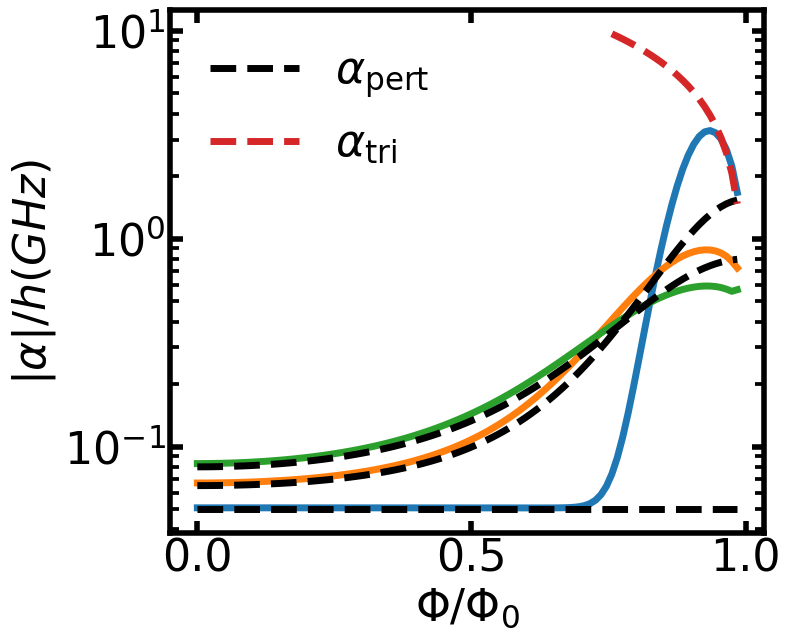

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.linalg import eigh
import math

# ======== Parameters ========
Phi0 = 1.0
Delta = 50.7
Tp = 1.0
p = 20
N = 1500
Ec = 0.2
dφ = 2 * np.pi / N
lam = 4 * Ec / dφ**2

phi_vals = np.linspace(-np.pi, np.pi, N)
phi_vals_H = np.linspace(-np.pi, np.pi, N)

# ======== Shared Potential Function ========
def V_exact_flux(phi, Phi, Tp):
    if Phi == 0:
        return 0
    Λ = np.pi * Phi / Phi0
    prefac = -Phi0 / (2 * np.pi * Phi)
    f = lambda θ: Delta * np.sqrt(max(0, 1 - Tp * np.sin(θ/2)**2))
    I, _ = quad(f, phi - Λ, phi + Λ, limit=300)
    return p * prefac * I

# ======== Figure 1: Anharmonicity ========

# 1. Calculation Functions
def build_H_phase_numeric(Phi, phi_vals, Ec, Tp, periodic=False):
    dphi = phi_vals[1] - phi_vals[0]
    N = len(phi_vals)
    V_vec = np.array([V_exact_flux(phi, Phi, Tp) for phi in phi_vals])
    V_vec = V_vec - np.min(V_vec)
    diag = np.full(N, 8 * Ec / dphi**2)
    off  = np.full(N - 1, -4 * Ec / dphi**2)
    H_kin = np.diag(diag) + np.diag(off, 1) + np.diag(off, -1)
    if periodic:
        H_kin[0, -1] = H_kin[-1, 0] = -4 * Ec / dphi**2
    return H_kin + np.diag(V_vec), V_vec

# 2. Compute Data
flux_range = np.linspace(0.0001, 0.985, 100)
Tp_list = [1, 0.9, 0.8]
linestyles = ['-', '--', ':']
E_levels = {Tp: [] for Tp in Tp_list}

# Numeric Spectrum
for Tp_i in Tp_list:
    for Phi in flux_range:
        H, _ = build_H_phase_numeric(Phi=Phi, phi_vals=phi_vals_H, Ec=Ec, Tp=Tp_i, periodic=True)
        E_vals, _ = eigh(H)
        E_levels[Tp_i].append(E_vals[:3])
    E_levels[Tp_i] = np.array(E_levels[Tp_i])

# Numeric Anharmonicity
anh = {}
analytic_anh = {}
for Tp_i in Tp_list:
    E = E_levels[Tp_i]
    anh[Tp_i] = (E[:, 1] - E[:, 0]) - (E[:, 2] - E[:, 1])
    # Analytic Perturbation
    sin_sq = np.sin(np.pi * flux_range / (2 * Phi0))**2
    analytic_anh[Tp_i] = -(-0.25 + (3*(Tp_i - 1)) / (4*(1 - Tp_i * sin_sq)**2)) * Ec

# Triangular Approximation
alpha0, alpha1, alpha2 = 1.01879, 2.33811, 3.24820
airy_comb = alpha2 - 2 * alpha1 + alpha0

def slope_A(Phi, a=0.5, Delta=50.7, p=20):
    return - p*(Delta/np.pi) * (Phi0/Phi) * (1- np.cos(np.pi * Phi/(2*Phi0))- np.sin(np.pi * Phi/(2*Phi0)))

triangular_anh = np.array([airy_comb * (4 * Ec)**(1/3) * slope_A(Φ)**(2/3) for Φ in flux_range])
mask = flux_range > 0.75

# 3. Plotting
fig1, axB = plt.subplots(figsize=(8, 6.5)) # Adjusted size for single plot

# Plot numeric (colored) - LABELS REMOVED as per request
for Tp_i, ls in zip(Tp_list, linestyles):
    axB.plot(flux_range, anh[Tp_i], lw=5, label=None) 

# Plot Analytic (black dashed) - LABEL KEPT
first_pert = True
for Tp_i in Tp_list:
    axB.plot(
        flux_range, analytic_anh[Tp_i],
        ls='--', lw=5, color='k',
        label=r'$\alpha_{\mathrm{pert}}$' if first_pert else None
    )
    first_pert = False

def setup(ax):
    ax.tick_params(direction='in', length=13, width=5, colors='black')
    ax.spines['left'].set_linewidth(4)
    ax.spines['right'].set_linewidth(4)
    ax.spines['top'].set_linewidth(4)
    ax.spines['bottom'].set_linewidth(4)
    #ax.spines['right'].set_color('none')
    #ax.spines['left'].set_color('none')
    #ax.yaxis.set_major_locator(ticker.NullLocator())
    #ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(which='major', direction='in',width=4.00,length=9,labelsize=32)
    ax.tick_params(which='major', direction='in',width=4.00,length=9,labelsize=32)
    ax.tick_params(which='minor', direction='in', width=2.70,length=6.5)
    ax.tick_params(which='minor', direction='in',width=2.70,length=6.5)
    ax.patch.set_alpha(0.0) 

setup(axB)
# Plot Triangular - LABEL KEPT
axB.plot(flux_range[mask], -triangular_anh[mask], label=r'$\alpha_{\rm tri}$', lw=5, ls='--', color='C3')

# 4. Styling (Fonts increased by ~30%)
axB.set_yscale('log')
# Original 24 -> New 32
axB.set_xlabel(r'$\Phi/\Phi_0$', fontsize=32)
axB.set_ylabel(r'$|\alpha|/h (GHz)$', fontsize=32)

# Increase Tick label size (Assuming orig ~16 -> 22)
axB.tick_params(axis='both', which='major', labelsize=32)

# Legend only contains dotted lines
axB.legend(fontsize=32, frameon=False) 
fig1.savefig('Figinset.pdf', format='pdf', bbox_inches='tight')

plt.tight_layout()
plt.show()

C:\Users\longyu\AppData\Local\Temp\ipykernel_108580\1465494716.py:28: ComplexWarning: Casting complex values to real discards the imaginary part
  H[0, -1] = -lam * np.exp(1j*θ)
C:\Users\longyu\AppData\Local\Temp\ipykernel_108580\1465494716.py:29: ComplexWarning: Casting complex values to real discards the imaginary part
  H[-1, 0] = -lam * np.exp(-1j*θ)


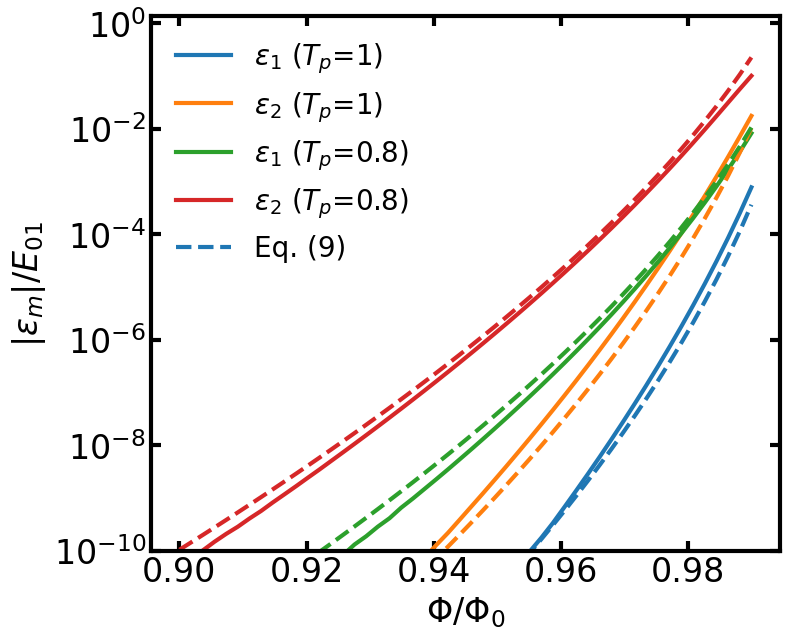

In [ ]:
# ======== Figure 2: Charge Dispersion ========

# 1. Compute Helper
def compute_for_p(p, Tp):
    # Exact potential locally defined to capture p
    def V_exact(phi, Φ, Tp):
        Λ = np.pi * Φ / Phi0
        prefac = -Phi0 / (2 * np.pi * Φ)
        f = lambda θ: Delta * np.sqrt(max(0, 1 - Tp * np.sin(θ/2)**2))
        I, _ = quad(f, phi - Λ, phi + Λ, limit=300)
        return p * prefac * I
    
    flux_values = np.linspace(0.9, 0.99, 50)
    Eeps = []
    e1_num = []; e2_num = []; anh = []
    e1_ana = []; e2_ana = []

    for Φ in flux_values:
        # Numeric eigen-splitting
        ev0 = evπ = None
        V_vec = np.array([V_exact(phi, Φ, Tp) for phi in phi_vals])
        V_shift = V_vec - V_vec.min()
        diag = lam * (2 + V_shift/lam)
        off  = -lam * np.ones(N-1)

        for θ in (0.0, np.pi):
            H = np.diag(diag) + np.diag(off, 1) + np.diag(off, -1)
            H[0, -1] = -lam * np.exp(1j*θ)
            H[-1, 0] = -lam * np.exp(-1j*θ)
            eigs = np.linalg.eigh(H)[0].real
            if θ == 0.0:
                ev0 = eigs
            else:
                evπ = eigs

        E01 = ev0[1] - ev0[0]
        Eeps.append(E01)
        e1_num.append(abs((ev0[1] - evπ[1]) / E01))
        e2_num.append(abs((ev0[2] - evπ[2]) / E01))
        anh.append(ev0[2] - 2*ev0[1] + ev0[0])

        # Analytic ε_m
        def eps_ana(m, Φ, Tp):
            V_vec = np.array([V_exact(phi, Φ, Tp) for phi in phi_vals])
            EJ= (np.max(V_vec) - np.min(V_vec))/2
            pref = ((-1)**m * Ec * 2**(4*m + 5) * math.sqrt(2/np.pi) / math.factorial(m))
            pw = (EJ / (2*Ec))**(0.5*m + 0.75)
            return abs(pref * pw * math.exp(-math.sqrt(8*EJ / Ec)) / E01)

        e1_ana.append(eps_ana(1, Φ,Tp))
        e2_ana.append(eps_ana(2, Φ,Tp))

    return (np.array(Eeps),
            np.array(e1_num), np.array(e2_num), np.array(anh),
            np.array(e1_ana), np.array(e2_ana))

# 2. Calculate Data
E20, e1_20, e2_20, anh20, e1_ana20, e2_ana20 = compute_for_p(20, 1.0)
E06, e1_06, e2_06, anh06, e1_ana06, e2_ana06 = compute_for_p(20, 0.8)

flux_values = np.linspace(0.9, 0.99, 50)
# 3. Plotting
fig2, axL = plt.subplots(figsize=(8, 6.5))

# p = 20 numeric
axL.plot(flux_values, e1_20, 'C0-', linewidth=3, label=r'$\epsilon_1$ ($T_p$=1)')
axL.plot(flux_values, e2_20, 'C1-', linewidth=3, label=r'$\epsilon_2$ ($T_p$=1)')

axL.plot(flux_values, e1_06, 'C2-', linewidth=3, label=r'$\epsilon_1$ ($T_p$=0.8)')
axL.plot(flux_values, e2_06, 'C3-', linewidth=3, label=r'$\epsilon_2$ ($T_p$=0.8)')

# Analytic curves for Tp=1
axL.plot(flux_values, e1_ana20, color='C0', linestyle='--', linewidth=3, label=r'Eq. (9)')
axL.plot(flux_values, e2_ana20, color='C1', linestyle='--', linewidth=3)

# Analytic curves for Tp=0.8
axL.plot(flux_values, e1_ana06, color='C2', linestyle='--', linewidth=3)
axL.plot(flux_values, e2_ana06, color='C3', linestyle='--', linewidth=3)

axL.set_xscale('linear')
axL.set_yscale('log')
axL.set_ylim(bottom=1e-10)
axL.set_xlabel(r'$\Phi/\Phi_0$', fontsize=24)
axL.set_ylabel(r'$|\epsilon_m|/E_{01}$', fontsize=24)
axL.legend(fontsize=20, frameon=False)
setup(axL)
plt.tight_layout()
fig2.savefig('Fig3.pdf', format='pdf', bbox_inches='tight')
plt.show()

Fig 5:

C:\Users\longyu\AppData\Local\Temp\ipykernel_41756\2367582843.py:41: KwantDeprecationWarning: The 'args' parameter has been deprecated since version 1.4 -- Instead, provide named parameters as a dictionary via 'params'.
  smatrix = kwant.smatrix(syst, energy=0, args=[par])
c:\Users\longyu\anaconda3\envs\Kwant\Lib\site-packages\kwant\solvers\common.py:151: KwantDeprecationWarning: The 'args' parameter has been deprecated since version 1.4 -- Instead, provide named parameters as a dictionary via 'params'.
  lhs, norb = syst.hamiltonian_submatrix(args, sparse=True,
c:\Users\longyu\anaconda3\envs\Kwant\Lib\site-packages\kwant\solvers\common.py:204: KwantDeprecationWarning: The 'args' parameter has been deprecated since version 1.4 -- Instead, provide named parameters as a dictionary via 'params'.
  prop, stab = lead.modes(energy, args, params=params)
c:\Users\longyu\anaconda3\envs\Kwant\Lib\site-packages\kwant\system.py:330: KwantDeprecationWarning: The 'args' parameter has been deprecated

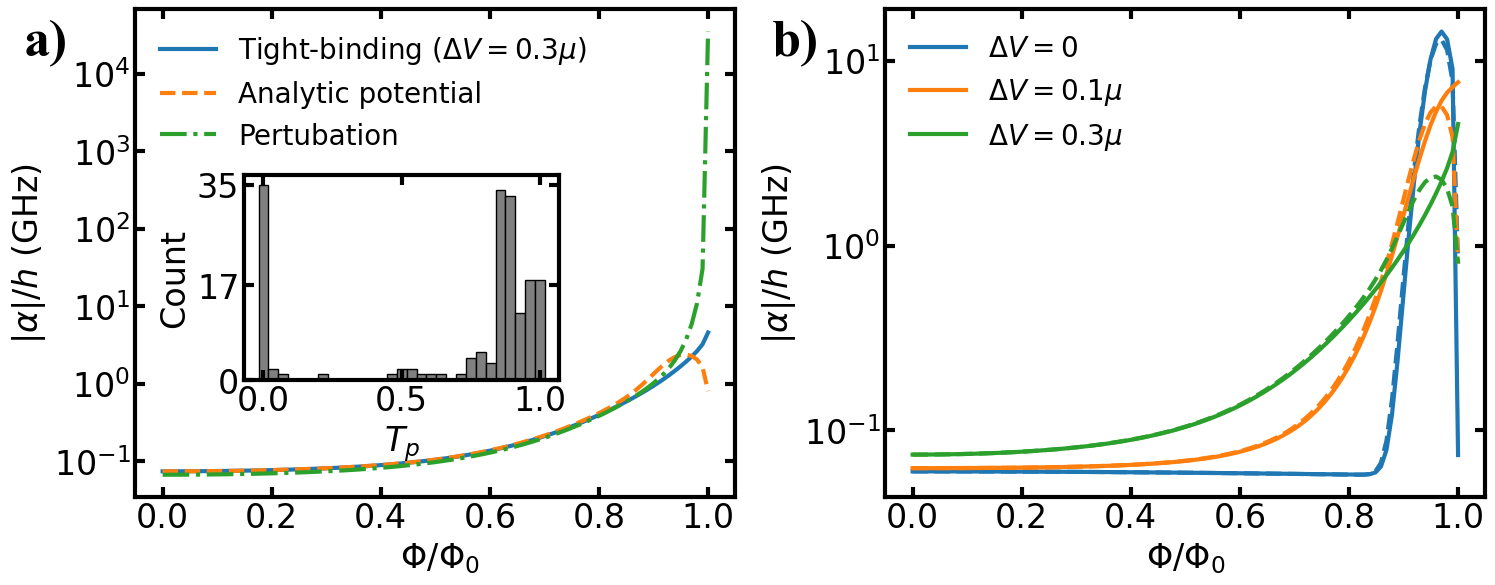

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from types import SimpleNamespace
import kwant
import pandas as pd
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import function as func

# Load from CSV: we want only dV = 0.3*mu
df = pd.read_csv("anharmonicity_all.csv")
mu = 5.79
factor = 0.3
dv = factor * mu
target_dV = dv
sub_df = df[np.isclose(df["dV"], target_dV)]

flux_vals_csv = sub_df["flux"].values
anh_tb_vals = sub_df["anh_tb"].values
anh_pot_vals = sub_df["anh_pot"].values
dV_list = [0.00 * mu, 0.1 * mu, 0.3 * mu]
colors = ['C0', 'C1', 'C2']
labels = [r'$\Delta V=0$', r'$\Delta V=0.1\mu$', r'$\Delta V=0.3\mu$']
# Define the potential function
def pot_func(site, Vg, dV, a, W):
    (x, y) = site.pos
    return Vg - dV

W = 300  # Width of the wire
L=10
a = 10  # Lattice constant
flux_range = np.linspace(0.0001, 1, 100)
Phi0 = 1
Ec = 2e-1 
# Define parameters
par = SimpleNamespace(t=2.3, mu=mu, U0=0, flux=0.0, Vg=0, dV=dv, yc=(W-1)*a/2, seed='0')
Delta = 0.0507

# Set the potential function for the system
syst = func.make_system_wire(a=a, W=W, L=L, pot=pot_func)
smatrix = kwant.smatrix(syst, energy=0, args=[par])
N, M = [len(li.momenta) // 2 for li in smatrix.lead_info]
s = smatrix.data

# Divide the scattering matrix into four blocks based on N and M
S11 = s[:N, :M]
S12 = s[:N, M:]
S21 = s[N:, :M]
S22 = s[N:, M:]

# Compute the matrix product of the upper right and lower left blocks
product_matrix = np.dot(S12.conj(), S21)

# Find the eigenvalues of the product matrix
eigenvalues = np.linalg.eigvals(product_matrix)
eigenvalues_real = eigenvalues.real

# Reverse the order of the eigenvalues
eigenvalues_real_reversed = eigenvalues_real[::-1]


# --- 4) Totally analytic formula anharmonicity from pertubation ---
# — assume you have already computed eigenvalues_real_reversed and assigned:
Tp_array = eigenvalues_real_reversed

# Pre‐compute some helpers over the entire flux_range
x = np.pi * flux_range / Phi0
sin_sq = np.sin(np.pi * flux_range / (2*Phi0))**2
sinc_x = np.sinc(x/np.pi)   # numpy’s sinc is already normalized: sinc(u)=sin(pi u)/(pi u)

# Allocate V2 and V4
V2 = np.zeros_like(flux_range)
V4 = np.zeros_like(flux_range)

# Loop over each channel transmission Tp
for Tp_p in Tp_array:
    # 1) V^(2)_p(0,Φ)
    denom = 4 * np.sqrt(1 - Tp_p * sin_sq)
    V2_p = 2* Delta * Tp_p * sinc_x / denom
    V2   += V2_p

    # 2) the bracketed factor for V^(4)_p
    bracket = -0.25 + 3*(Tp_p - 1) / (4 * (1 - Tp_p * sin_sq)**2)
    V4   += V2_p * bracket

# 3) anharmonicity from Eq. (17):
analytic_anh = Ec * V4 / V2

# Now create a 1×2 canvas
fig, (axL, axR) = plt.subplots(1, 2, figsize=(15, 6.5))


# —— Left subplot: anharmonicity curves —— 
setup(axL)

# 1. TB result (solid)
axL.plot(flux_vals_csv, np.abs(anh_tb_vals),
         label=fr'Tight-binding ($\Delta V={factor}\mu$)', linewidth=3, linestyle='-', color='C0')

# 2. Analytic potential result (dashed)
axL.plot(flux_vals_csv, np.abs(anh_pot_vals),
         label='Analytic potential', linewidth=3, linestyle='--', color='C1')

# 3. Perturbation theory result (dotted or dashed)
axL.plot(flux_range, np.abs(analytic_anh),
         label='Pertubation', linewidth=3, linestyle='-.', color='C2')
# Create the inset inside axL
ax_hist = inset_axes(axL, width="35%", height="35%", loc='center left',
                     bbox_to_anchor=(0.17, -0.15, 1.5, 1.2), bbox_transform=axL.transAxes)
setup(ax_hist)
# Histogram parameters
n = 30
x = 0.5 / (n - 1)
bins = np.linspace(-x, 1 + x, n)
counts, _, _ = ax_hist.hist(eigenvalues_real_reversed,
                            bins=bins,
                            align='mid',
                            edgecolor='black',
                            facecolor='gray',
                            density=False)

# Axis labels (matching main legend size)
ax_hist.set_xlabel(r'$T_p$', fontsize=24)
ax_hist.set_ylabel("Count", fontsize=24)
# ax_hist.set_xlim(0, 1)
ax_hist.set_yticks([0, 17, np.max(counts)])
ax_hist.set_xticks([0, 0.5, 1])
axL.set_ylabel(r'$|\alpha|/h$ (GHz)', fontsize=24)
axL.set_yscale('symlog', linthresh=0.01)
axL.set_xlabel(r' $\Phi/\Phi_0$', fontsize=24)
axL.text(-0.15, 0.98, 'a)', transform=axL.transAxes,fontweight='bold',fontfamily='Times New Roman',fontsize=38, ha='center', va='top')
axL.legend(fontsize=20, frameon=False)


# —— Right subplot: “This should be the right panel” —— 
# again, just old ax1 → axR
setup(axR)

for dV, color, label in zip(dV_list, colors, labels):
    sub_df = df[np.isclose(df["dV"], dV)]
    flux_vals = sub_df["flux"].values
    anh_tb_vals = sub_df["anh_tb"].values
    anh_pot_vals = sub_df["anh_pot"].values

    # Solid = numeric TB
    axR.plot(flux_vals, np.abs(anh_tb_vals),
            linestyle='-', color=color, linewidth=3,
            label=f'{label}')

    # Dashed = analytic potential
    axR.plot(flux_vals, np.abs(anh_pot_vals),
            linestyle='--', color=color, linewidth=3,
    )
            # label=f'{label} (analytic)')

axR.set_xlabel(r'$\Phi/\Phi_0$', fontsize=24)
axR.set_ylabel(r'$|\alpha|/h$ (GHz)', fontsize=24)
axR.set_yscale('symlog', linthresh=0.01)
axR.text(-0.15, 0.98, 'b)', transform=axR.transAxes,fontweight='bold',fontfamily='Times New Roman', fontsize=38, ha='center', va='top')
axR.legend(fontsize=20, frameon=False,  columnspacing=0.1)

# Final layout tweaks
plt.subplots_adjust(
    bottom=0.15, left=0.08,
    right=0.98, top=0.90,
    wspace=0.25
)

fig.savefig('Fig5.pdf', format='pdf', bbox_inches='tight')
plt.show()


Fig 5 data:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import kwant
import function as func
from types import SimpleNamespace
from scipy.integrate import quad
import os 

# --- 0) Constants ---
Delta    = 0.0507           # superconducting gap (GHz)
W, L, a  = 300, 10, 10      # lattice dims
A        = (W-0.5)*(L-1)*a**2
Phi0     = 1.0              # flux quantum
Ec       = 2e-1             # charging energy (GHz)
mu       = 5.79
theta_scalar    = 0.0
N        = 1500
dφ       = 2*np.pi/N
lam      = 4*Ec/dφ**2
i=0

# φ‑grid and flux grid
phi_vals   = np.linspace(-np.pi, np.pi, N)
flux_range = np.linspace(0.0001, 1, 100)


theta    = phi_vals.copy()    # same grid
d_theta  = 2*np.pi/N

# --- 1) Build Kwant system once ---
def pot_func(site, Vg, dV, a, W):
    return Vg - dV
    
def calculate_V_phi(smatrix, phi_value, Delta):
    energy_pos, energy_neg = func.energy_level_tight_binding(
        smatrix=smatrix, phi=phi_value, Delta=Delta
    )
    V_phi = np.sum(energy_neg) * 1000
    return V_phi
syst = func.make_system_wire(a=a, W=W, L=L, pot=pot_func)

# --- 2) Extract T_p at zero flux (spectral weights) ---
par0   = SimpleNamespace(t=2.3, mu=mu, U0=0,
                         flux=0.0, Vg=0, dV=0,
                         yc=(W-1)*a/2, seed='1')


# --- 4) Single function computing both α_TB and α_pot for a given dV ---
def run_models(dV_value):
    global i
    # prepare lists
    anh_tb  = []
    anh_pot = []

    # reference spacing at zero‐flux for TB
    par_ref = SimpleNamespace(t=2.3, mu=mu, U0=0,
                              flux=0.0, Vg=0, dV=dV_value,
                              yc=(W-1)*a/2, seed='1')
    sm_ref = kwant.smatrix(syst, energy=0, args=[par_ref])
    N0, M0 = [len(li.momenta)//2 for li in sm_ref.lead_info]
    S0     = sm_ref.data
    S12_0  = S0[:N0, M0:]
    S21_0  = S0[N0:, :M0]
    Tp_array = np.real(np.linalg.eigvals(S12_0.conj() @ S21_0))
    Tp_array = np.clip(Tp_array, 0.0, 1.0)
    g_table  = np.zeros((len(Tp_array), N))
    for k, Tp in enumerate(Tp_array):
        g_table[k] = Delta * np.sqrt(1 - Tp * np.sin(theta/2)**2)

    # 3) FFT each channel
    G_table = np.fft.fft(g_table, axis=1)

    def V_exact_allphi(Phi):
        Λ = np.pi * Phi / Phi0
        # build W_m
        m = np.arange(N)
        W = np.empty(N)
        W[0] = 2*Λ
        # for m>N/2 use negative frequencies wrap
        m1 = m[1:N//2]
        W[m1] = 2*np.sin(m1*Λ)/m1
        m2 = m[N//2+1:]
        mm = m2 - N  # negative indices
        W[N//2+1:] = 2*np.sin(mm*Λ)/mm
        # mode‐wise multiplication + IFFT
        convs = np.fft.ifft(G_table * W[None, :], axis=1).real
        prefac = -Phi0/(2*np.pi*Phi)
        # sum over Tp channels, apply factor, return full φ‐vector
        return (2*prefac * convs.sum(axis=0)) * 1000

    # loop over flux
    for Φ in flux_range:
        # — TB model —
        par = SimpleNamespace(t=2.3, mu=mu, U0=0,
                              flux=Φ/A, Vg=0, dV=dV_value,
                              yc=(W-1)*a/2, seed='1')
        sm = kwant.smatrix(syst, energy=0, args=[par])
        H  = np.zeros((N,N),complex)
        for j in range(N):
            Vφ        = calculate_V_phi(sm, phi_vals[j], Delta)
            H[j,j]    = 2 + Vφ/lam
            if j>0:   H[j,j-1] = -1
            if j<N-1: H[j,j+1] = -1
        H[0,-1] = -np.exp(1j*theta_scalar)
        H[-1,0] = -np.exp(-1j*theta_scalar)
        H       *= lam
        ev       = np.sort(np.real(np.linalg.eigh(H)[0]))[:3]
        # — Analytic phase‑Hamiltonian via vectorized V_exact_allphi —
        Vphi_vec = V_exact_allphi(Φ)     # length‑N array of V(φ_j, Φ)

        # build Hphi with one vectorized diag assignment
        Hphi = np.zeros((N,N), complex)
        np.fill_diagonal(Hphi, 2 + Vphi_vec/lam)
        # off‑diagonals
        idx = np.arange(N-1)
        Hphi[idx, idx+1] = Hphi[idx+1, idx] = -1
        # wrap boundary
        Hphi[0, -1]     = -np.exp(1j*theta_scalar )
        Hphi[-1, 0]     = -np.exp(-1j*theta_scalar )

        Hphi *= lam
        evp        = np.sort(np.real(np.linalg.eigh(Hphi)[0]))[:3]
        # Compute anharmonicities
        anh_tb_val  = ev[2]  - 2 * ev[1]  + ev[0]
        anh_pot_val = evp[2] - 2 * evp[1] + evp[0]

        # Append to results
        anh_tb.append(anh_tb_val)
        anh_pot.append(anh_pot_val)

        # --- Append to CSV ---
        filename = "anharmonicity_all.csv"
        header = "dV,flux,anh_tb,anh_pot"

        # Only write header if file does not exist
        write_header = not os.path.exists(filename)

        with open(filename, 'a') as f:
            if write_header:
                f.write(header + '\n')
            f.write(f"{dV_value:.6f},{Φ:.6f},{anh_tb_val:.6f},{anh_pot_val:.6f}\n")
        i += 1
        print(f'{i}: dV={dV_value:.4f}, Φ={Φ:.4f}, α_TB={anh_tb_val:.5f}, α_pot={anh_pot_val:.5f}')
    return np.array(anh_tb), np.array(anh_pot)

# --- 5) Plot for three dV’s ---
# dV_list    = [0.00*mu, 0.1*mu, 0.3*mu]
# styles     = ['-', '-', '-']
# colors     = ['C0', 'C1', 'C2']
# labels     = [r'$\Delta V=0$', r'$\Delta V=0.1\mu$', r'$\Delta V=0.3\mu$']
dV_list    = [ 0.0*mu]
styles     = [ '-']
colors     = [ 'C1']
labels     = [ r'$\Delta V=0.0\mu$']
fig, ax = plt.subplots(figsize=(10,8))
setup(ax)

for dV, ls, c, lbl in zip(dV_list, styles, colors, labels):
    tb_curve, pot_curve = run_models(dV)
    # solid = numeric TB
    ax.plot(flux_range, np.abs(tb_curve),
            linestyle=ls, color=c, linewidth=3,
            label=f' {lbl}')
    # dashed = analytic potential
    ax.plot(flux_range, np.abs(pot_curve),
            linestyle='--', color=c, linewidth=3,
            )

ax.set_xlabel(r'$\Phi/\Phi_0$', fontsize=24)
ax.set_ylabel(r'$|\alpha|$ (GHz)',  fontsize=24)
ax.set_yscale('symlog', linthresh=0.01)
ax.legend(fontsize=16, frameon=False, ncol=2)
plt.tight_layout()
plt.show()
